In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from scipy.optimize import linear_sum_assignment
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings("ignore")

# 1-layer KAN Encoder
class KANEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(input_dim, hidden_dim) * 0.4)
        self.bias = nn.Parameter(torch.zeros(hidden_dim))
        self.a = nn.Parameter(torch.ones(hidden_dim))
        self.b = nn.Parameter(torch.zeros(hidden_dim))
        self.c = nn.Parameter(torch.ones(hidden_dim))
        self.d = nn.Parameter(torch.zeros(hidden_dim))

    def kan_activation(self, x):
        return self.a * torch.tanh(self.b * x + self.c) + self.d

    def forward(self, x):
        x = F.linear(x, self.weights.T, self.bias)
        x = x + torch.rand_like(x) * 0.2
        return self.kan_activation(x)

# 1-layer Tanh Decoder
class TanhDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.linear(x)
        x = self.activation(x)
        x = x + torch.rand_like(x) * 0.2
        return x

# Autoencoder
class AdversarialAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, noise_factor=0.1):
        super().__init__()
        self.encoder = KANEncoder(input_dim, hidden_dim)
        self.decoder = TanhDecoder(hidden_dim, input_dim)
        self.noise_factor = noise_factor

    def forward(self, x, add_noise=True):
        if add_noise:
            x_noisy = x + self.noise_factor * torch.randn_like(x)
        else:
            x_noisy = x
        encoded = self.encoder(x_noisy)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Linear Classifier - FIXED
class LinearClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.fc(x).squeeze(-1)

def mask_random_positions(x, mask_ratio=0.25):
    """
    Randomly mask ratio% of positions in tensor x with their mean values
    x: input tensor of shape (batch_size, features)
    """
    batch_size, feat_dim = x.shape
    mask = torch.rand(batch_size, feat_dim, device=x.device) < mask_ratio

    # Calculate means safely for masked positions
    feature_means = torch.zeros(feat_dim, device=x.device)
    for i in range(feat_dim):
        masked_vals = x[:, i][mask[:, i]]
        if len(masked_vals) > 0:
            feature_means[i] = masked_vals.mean()
        else:
            feature_means[i] = x[:, i].mean()

    # Create masked tensor
    x_masked = x.clone()
    for i in range(feat_dim):
        x_masked[:, i][mask[:, i]] = feature_means[i]

    return x_masked

def train_autoencoder(model, loader, optimizer_enc, optimizer_dec, device):
    model.train()
    total_loss = 0
    for data, _ in loader:
        # masked_data = mask_random_positions(data)
        # masked_data = masked_data.to(device)
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        data = data.to(device)
        _, decoded = model(data)
        loss = F.mse_loss(decoded, data)
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# FIXED: Use BCEWithLogitsLoss instead of BCELoss
def train_classifier(encoder, classifier, loader, optimizer, device):
    encoder.eval()
    classifier.train()
    total_loss = 0
    # Changed from BCELoss to BCEWithLogitsLoss
    bce_with_logits = nn.BCEWithLogitsLoss()

    for data, labels in loader:
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            embeddings = encoder(data)
        logits = classifier(embeddings)

        # BCEWithLogitsLoss applies sigmoid internally, so we don't need to
        loss = bce_with_logits(logits, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def pseudo_label_dataset(encoder, dataset, device, n_clusters=2):
    loader = DataLoader(dataset, batch_size=256)
    encoder.eval()
    embeddings = []
    with torch.no_grad():
        for data, _ in loader:
            data = data.to(device)
            emb = encoder(data)
            embeddings.append(emb.cpu().numpy())
    embeddings = np.vstack(embeddings)
    pca = PCA(n_components=2)
    embeddings = pca.fit_transform(embeddings)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)
    return cluster_labels

# Additional debugging function
def check_tensor_validity(tensor, name):
    """Check if tensor contains NaN or Inf values"""
    if torch.isnan(tensor).any():
        print(f"Warning: {name} contains NaN values")
        return False
    if torch.isinf(tensor).any():
        print(f"Warning: {name} contains Inf values")
        return False
    return True

# Training loop with additional error checking
def safe_train_classifier(encoder, classifier, loader, optimizer, device):
    encoder.eval()
    classifier.train()
    total_loss = 0
    bce_with_logits = nn.BCEWithLogitsLoss()

    for batch_idx, (data, labels) in enumerate(loader):
        data, labels = data.to(device), labels.to(device)

        # Check input validity
        if not check_tensor_validity(data, f"batch_{batch_idx}_data"):
            continue
        if not check_tensor_validity(labels, f"batch_{batch_idx}_labels"):
            continue

        optimizer.zero_grad()
        with torch.no_grad():
            embeddings = encoder(data)
            if not check_tensor_validity(embeddings, f"batch_{batch_idx}_embeddings"):
                continue

        logits = classifier(embeddings)
        if not check_tensor_validity(logits, f"batch_{batch_idx}_logits"):
            continue

        loss = bce_with_logits(logits, labels.float())
        if not check_tensor_validity(loss, f"batch_{batch_idx}_loss"):
            continue

        loss.backward()

        # Gradient clipping to prevent gradient explosion
        torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader) if len(loader) > 0 else 0

In [30]:
# Data preparation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = pd.read_csv('../multi_threshold_20250512_112109/experiment_20250512_112127/transformed_data.csv')
# X = pd.read_csv('../Dataset/ABIDE2.csv')
label_map = {'Cancer': 0, 'Normal': 1}
y = X['group'].map(label_map).values
X = X.drop(['group'], axis=1)
X = X.select_dtypes(include=[np.number]).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_tensor = torch.FloatTensor(X_scaled)
y_tensor = torch.FloatTensor(y)
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)

Warmup Epoch 1/70, Loss: 1.0163
Warmup Epoch 2/70, Loss: 0.7542
Warmup Epoch 3/70, Loss: 0.7017
Warmup Epoch 4/70, Loss: 0.6344
Warmup Epoch 5/70, Loss: 0.5900
Warmup Epoch 6/70, Loss: 0.5654
Warmup Epoch 7/70, Loss: 0.5404
Warmup Epoch 8/70, Loss: 0.5186
Warmup Epoch 9/70, Loss: 0.5026
Warmup Epoch 10/70, Loss: 0.4853
Warmup Epoch 11/70, Loss: 0.4724
Warmup Epoch 12/70, Loss: 0.4586
Warmup Epoch 13/70, Loss: 0.4458
Warmup Epoch 14/70, Loss: 0.4363
Warmup Epoch 15/70, Loss: 0.4227
Warmup Epoch 16/70, Loss: 0.4153
Warmup Epoch 17/70, Loss: 0.4034
Warmup Epoch 18/70, Loss: 0.3937
Warmup Epoch 19/70, Loss: 0.3859
Warmup Epoch 20/70, Loss: 0.3796
Warmup Epoch 21/70, Loss: 0.3726
Warmup Epoch 22/70, Loss: 0.3649
Warmup Epoch 23/70, Loss: 0.3620
Warmup Epoch 24/70, Loss: 0.3546
Warmup Epoch 25/70, Loss: 0.3509
Warmup Epoch 26/70, Loss: 0.3453
Warmup Epoch 27/70, Loss: 0.3407
Warmup Epoch 28/70, Loss: 0.3398
Warmup Epoch 29/70, Loss: 0.3352
Warmup Epoch 30/70, Loss: 0.3304
Warmup Epoch 31/70,

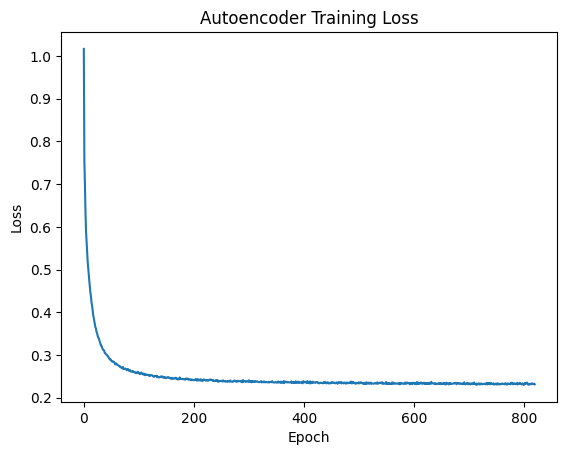

Final Clustering Accuracy: 0.5767
Final Clustering F1 Score: 0.5414


In [32]:
np.random.seed(42)
# Model setup
input_dim = X.shape[1]
hidden_dim = 256
model = AdversarialAutoencoder(input_dim, hidden_dim).to(device)
optimizer_enc = torch.optim.Adam(model.encoder.parameters(), lr=0.0024)
optimizer_dec = torch.optim.Adam(model.decoder.parameters(), lr=0.001)

# Training parameters
n_warmup = 70
n_cycles = 50
unsup_epochs = 15
sup_epochs = 25
# Warmup: Unsupervised training
losses = []
for epoch in range(n_warmup):
    loss = train_autoencoder(model, train_loader, optimizer_enc, optimizer_dec, device)
    losses.append(loss)
    print(f'Warmup Epoch {epoch+1}/{n_warmup}, Loss: {loss:.4f}')

# Alternating unsupervised and semi-supervised training

for cycle in range(n_cycles):
    # Unsupervised phase
    for epoch in range(unsup_epochs):
        loss = train_autoencoder(model, train_loader, optimizer_enc, optimizer_dec, device)
        losses.append(loss)
        # print(f'Cycle {cycle+1} Unsupervised Epoch {epoch+1}/{unsup_epochs}, Loss: {loss:.4f}')

    # Pseudo-labeling
    classifier = LinearClassifier(hidden_dim).to(device)
    cluster_labels = pseudo_label_dataset(model.encoder, dataset, device, n_clusters=2)
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    sup_indices = indices[:len(indices)//4]
    sup_labels = cluster_labels[sup_indices]
    sup_X = X_tensor[sup_indices]
    sup_y = torch.FloatTensor(sup_labels)
    sup_dataset = TensorDataset(sup_X, sup_y)
    sup_loader = DataLoader(sup_dataset, batch_size=256, shuffle=True)

    # Supervised phase: train classifier on embeddings
    optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=0.001)
    for epoch in range(sup_epochs):
        loss = train_classifier(model.encoder, classifier, sup_loader, optimizer_cls, device)
        # print(f'Cycle {cycle+1} Supervised Epoch {epoch+1}/{sup_epochs}, Classifier Loss: {loss:.4f}')

    classifier.eval()
    with torch.no_grad():
        all_embeddings = model.encoder(X_tensor.to(device))
        logits = classifier(all_embeddings)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).cpu().numpy().astype(int)
        true_labels = y_tensor.cpu().numpy().astype(int)
        acc = accuracy_score(true_labels, preds)
        f1 = f1_score(true_labels, preds, average='weighted')
        print(f'Cycle {cycle+1} Classifier True Accuracy: {acc:.4f}, F1: {f1:.4f}')
    classifier.train()

# Plot training loss
plt.plot(losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Final evaluation: clustering in latent space
model.eval()
with torch.no_grad():
    embeddings = model.encoder(X_tensor.to(device)).cpu().numpy()
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)
def best_map(y_true, y_pred):
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return {j: i for i, j in zip(*ind)}
mapping = best_map(y, cluster_labels)
aligned_preds = np.array([mapping[c] for c in cluster_labels])
acc = accuracy_score(y, aligned_preds)
f1 = f1_score(y, aligned_preds, average='weighted')
print(f'Final Clustering Accuracy: {acc:.4f}')
print(f'Final Clustering F1 Score: {f1:.4f}')

Warmup Epoch 1/70, Loss: 1.0300
Warmup Epoch 2/70, Loss: 0.7880
Warmup Epoch 3/70, Loss: 0.7094
Warmup Epoch 4/70, Loss: 0.6542
Warmup Epoch 5/70, Loss: 0.6035
Warmup Epoch 6/70, Loss: 0.5747
Warmup Epoch 7/70, Loss: 0.5519
Warmup Epoch 8/70, Loss: 0.5275
Warmup Epoch 9/70, Loss: 0.5080
Warmup Epoch 10/70, Loss: 0.4910
Warmup Epoch 11/70, Loss: 0.4770
Warmup Epoch 12/70, Loss: 0.4614
Warmup Epoch 13/70, Loss: 0.4519
Warmup Epoch 14/70, Loss: 0.4407
Warmup Epoch 15/70, Loss: 0.4283
Warmup Epoch 16/70, Loss: 0.4167
Warmup Epoch 17/70, Loss: 0.4068
Warmup Epoch 18/70, Loss: 0.3982
Warmup Epoch 19/70, Loss: 0.3888
Warmup Epoch 20/70, Loss: 0.3837
Warmup Epoch 21/70, Loss: 0.3739
Warmup Epoch 22/70, Loss: 0.3698
Warmup Epoch 23/70, Loss: 0.3610
Warmup Epoch 24/70, Loss: 0.3572
Warmup Epoch 25/70, Loss: 0.3533
Warmup Epoch 26/70, Loss: 0.3455
Warmup Epoch 27/70, Loss: 0.3444
Warmup Epoch 28/70, Loss: 0.3396
Warmup Epoch 29/70, Loss: 0.3342
Warmup Epoch 30/70, Loss: 0.3321
Warmup Epoch 31/70,

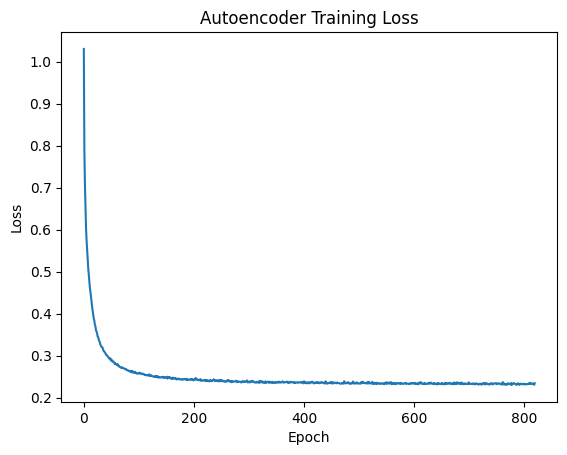

Final Clustering Accuracy: 0.5837
Final Clustering F1 Score: 0.5545


In [33]:
np.random.seed(42)
# Model setup
input_dim = X.shape[1]
hidden_dim = 256
model = AdversarialAutoencoder(input_dim, hidden_dim).to(device)
optimizer_enc = torch.optim.Adam(model.encoder.parameters(), lr=0.0024)
optimizer_dec = torch.optim.Adam(model.decoder.parameters(), lr=0.001)

# Training parameters
n_warmup = 70
n_cycles = 50
unsup_epochs = 15
sup_epochs = 25
# Warmup: Unsupervised training
losses = []
for epoch in range(n_warmup):
    loss = train_autoencoder(model, train_loader, optimizer_enc, optimizer_dec, device)
    losses.append(loss)
    print(f'Warmup Epoch {epoch+1}/{n_warmup}, Loss: {loss:.4f}')

# Alternating unsupervised and semi-supervised training

for cycle in range(n_cycles):
    # Unsupervised phase
    for epoch in range(unsup_epochs):
        loss = train_autoencoder(model, train_loader, optimizer_enc, optimizer_dec, device)
        losses.append(loss)
        # print(f'Cycle {cycle+1} Unsupervised Epoch {epoch+1}/{unsup_epochs}, Loss: {loss:.4f}')

    # Pseudo-labeling
    classifier = LinearClassifier(hidden_dim).to(device)
    cluster_labels = pseudo_label_dataset(model.encoder, dataset, device, n_clusters=2)
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    sup_indices = indices[:len(indices)//4]
    sup_labels = cluster_labels[sup_indices]
    sup_X = X_tensor[sup_indices]
    sup_y = torch.FloatTensor(sup_labels)
    sup_dataset = TensorDataset(sup_X, sup_y)
    sup_loader = DataLoader(sup_dataset, batch_size=256, shuffle=True)

    # Supervised phase: train classifier on embeddings
    optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=0.001)
    for epoch in range(sup_epochs):
        loss = train_classifier(model.encoder, classifier, sup_loader, optimizer_cls, device)
        # print(f'Cycle {cycle+1} Supervised Epoch {epoch+1}/{sup_epochs}, Classifier Loss: {loss:.4f}')

    classifier.eval()
    with torch.no_grad():
        all_embeddings = model.encoder(X_tensor.to(device))
        logits = classifier(all_embeddings)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).cpu().numpy().astype(int)
        true_labels = y_tensor.cpu().numpy().astype(int)
        acc = accuracy_score(true_labels, preds)
        f1 = f1_score(true_labels, preds, average='weighted')
        print(f'Cycle {cycle+1} Classifier True Accuracy: {acc:.4f}, F1: {f1:.4f}')
    classifier.train()

# Plot training loss
plt.plot(losses)
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Final evaluation: clustering in latent space
model.eval()
with torch.no_grad():
    embeddings = model.encoder(X_tensor.to(device)).cpu().numpy()
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings)
def best_map(y_true, y_pred):
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return {j: i for i, j in zip(*ind)}
mapping = best_map(y, cluster_labels)
aligned_preds = np.array([mapping[c] for c in cluster_labels])
acc = accuracy_score(y, aligned_preds)
f1 = f1_score(y, aligned_preds, average='weighted')
print(f'Final Clustering Accuracy: {acc:.4f}')
print(f'Final Clustering F1 Score: {f1:.4f}')

In [29]:
def transform_abide_data(input_file, n_components_dict, output_file):
    """
    Transform ABIDE data by applying PCA separately to different measurement groups

    Parameters:
    input_file: path to ABIDE CSV file
    n_components_dict: dictionary with components for each group
        e.g. {'area': 10, 'volume': 15, 'gyrification': 5, 'thickness': 20}
    output_file: path to save transformed CSV
    """
    # Read data
    df = pd.read_csv(input_file)

    # Extract group labels
    labels = df['group']

    # Define column patterns for each measurement type
    patterns = {
        'fsArea': 'fsArea',
        'fsVol': 'fsVol',
        'fsLGI': 'fsLGI',
        'fsCT': 'fsCT'
    }

    # Split data into measurement groups
    grouped_data = {}
    for group, pattern in patterns.items():
        cols = [col for col in df.columns if pattern.lower() in col.lower()]
        grouped_data[group] = df[cols]
        print(f"{group}: {len(cols)} features")

    # Apply PCA to each group
    transformed_groups = {}
    for group, data in grouped_data.items():
        n_comp = min(n_components_dict[group], data.shape[1])
        pca = PCA(n_components=n_comp)
        transformed = pca.fit_transform(StandardScaler().fit_transform(data))
        cols = [f"{group}_pc{i+1}" for i in range(n_comp)]
        transformed_groups[group] = pd.DataFrame(transformed, columns=cols)
        exp_var = sum(pca.explained_variance_ratio_)
        print(f"{group}: {exp_var:.3f} explained variance with {n_comp} components")

    # Combine transformed data
    result = pd.concat([transformed_groups[group] for group in patterns.keys()], axis=1)
    result['group'] = labels

    # Save to CSV
    result.to_csv(output_file, index=False)
    print(f"\nTransformed data saved to {output_file}")
    print(f"Final shape: {result.shape}")

    return result

# Example usage:
components = {
    'fsArea': 50,
    'fsVol': 70,
    'fsLGI': 50,
    'fsCT': 60
}

transformed_data = transform_abide_data(
    input_file='../Dataset/ABIDE2.csv',
    n_components_dict=components,
    output_file='../Dataset/ABIDE2_transformed.csv'
)

fsArea: 360 features
fsVol: 360 features
fsLGI: 360 features
fsCT: 360 features
fsArea: 0.723 explained variance with 50 components
fsVol: 0.743 explained variance with 70 components
fsLGI: 0.723 explained variance with 50 components
fsCT: 0.727 explained variance with 60 components

Transformed data saved to ../Dataset/ABIDE2_transformed.csv
Final shape: (1004, 231)


In [32]:
from Utils.Utils import transform_features

transform_features(
    data_path="../Dataset/ABIDE2_transformed.csv",
    skew_threshold=0.1,
    poly_degree=2,
    poly_threshold=0
)

Loading data from ../Dataset/ABIDE2_transformed.csv...
Original data shape: (1004, 231)
Number of numeric features: 230
Number of highly skewed features: 111
Number of features selected for polynomial transformation: 230
Generating interaction terms...
Standardizing features...
Transformed data saved to transformed_ABIDE2_transformed.csv
Final data shape: (1004, 26796)

Transformation Summary:
Visualizations saved to 'feature_transformations.png'


,fsArea_pc1,fsArea_pc2,fsArea_pc3,fsArea_pc4,fsArea_pc5,fsArea_pc6,fsArea_pc7,fsArea_pc8,fsArea_pc9,fsArea_pc10,...,fsCT_pc56_mul_fsCT_pc58,fsCT_pc56_mul_fsCT_pc59,fsCT_pc56_mul_fsCT_pc60,fsCT_pc57_mul_fsCT_pc58,fsCT_pc57_mul_fsCT_pc59,fsCT_pc57_mul_fsCT_pc60,fsCT_pc58_mul_fsCT_pc59,fsCT_pc58_mul_fsCT_pc60,fsCT_pc59_mul_fsCT_pc60,group
0,-0.373645,-0.096621,1.316018,-0.430340,0.410696,-1.280116,-0.494935,0.269370,1.092283,-0.143255,...,0.717951,1.082521,1.988331,-0.532802,-0.743042,-1.008775,0.484959,0.627986,0.944929,Cancer
1,-0.896075,-0.835581,-0.561485,-1.239396,0.158786,0.371049,-0.450038,-0.855985,0.491993,-0.573061,...,-1.031424,0.948640,0.308104,-1.266478,1.077086,1.309774,-0.800737,-0.930518,0.852711,Cancer
2,0.830549,-4.363596,0.481610,0.903607,-0.154176,-0.084218,1.282356,-0.183378,-0.589690,0.041732,...,0.385442,-0.793633,-0.609537,0.119866,-0.227907,0.282172,-0.437352,0.516964,-1.058288,Normal
3,0.404769,0.557805,-0.353597,-1.432190,0.454838,-1.212722,0.197215,0.197553,-0.049338,0.051635,...,-0.909093,-0.624322,0.479149,-1.295442,-0.820805,1.562311,0.540849,-0.983705,-0.669562,Cancer
4,-0.905550,0.569345,-1.133746,0.215698,1.817685,0.447689,0.107246,-0.803988,-0.352166,0.061383,...,0.092553,-0.423452,1.515578,-0.274090,1.158473,-3.787490,-0.023036,0.071363,-0.326099,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999,0.227949,-1.143946,0.768968,-1.018978,0.187440,-0.443671,-0.175905,0.935673,-0.934019,0.691049,...,-0.319507,-0.964372,0.874164,-0.026928,-0.074998,0.097912,0.259424,-0.324777,-0.971132,Normal
1000,0.603417,1.637444,0.628263,1.104521,0.559681,0.753102,1.727931,-2.363604,0.266175,0.524956,...,-0.761790,0.236049,-0.383509,-0.358670,0.103032,0.445533,-0.147974,-0.611898,0.190238,Normal
1001,-0.097143,-1.386215,-0.672939,-1.256651,0.443695,0.343856,0.640565,0.366833,0.190626,-0.559021,...,0.084584,0.246923,-0.461452,-0.011376,-0.030847,-0.126034,0.024294,0.094046,0.277330,Normal
1002,0.050834,0.021365,0.098779,-0.665187,-0.582021,1.001989,0.646289,-1.437862,0.392878,-0.051202,...,-0.848282,-0.420037,-0.913398,1.453868,0.663754,-1.465423,0.471818,-0.995053,-0.487705,Normal


In [34]:
import torch
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pickle
import json
from datetime import datetime
import os

def train_kan_autoencoder(X, y,
                         # Model parameters
                         hidden_dim=256,
                         noise_factor=0.1,

                         # Training parameters
                         n_warmup=70,
                         n_cycles=50,
                         unsup_epochs=15,
                         sup_epochs=25,
                         batch_size=128,

                         # Optimization parameters
                         lr_encoder=0.0024,
                         lr_decoder=0.001,
                         lr_classifier=0.001,

                         # Semi-supervised parameters
                         n_clusters=2,
                         sup_ratio=0.25,  # fraction of data used for supervised training

                         # Other parameters
                         device=None,
                         save_dir='./saved_models',
                         experiment_name=None,
                         save_best=True,
                         plot_loss=True,
                         verbose=True,
                         random_seed=42):
    """
    Train KAN Autoencoder with semi-supervised learning

    Parameters:
    -----------
    X : array-like, shape (n_samples, n_features)
        Input features
    y : array-like, shape (n_samples,)
        Target labels (for evaluation, not used in training)
    hidden_dim : int
        Dimension of the hidden representation
    noise_factor : float
        Noise factor for denoising autoencoder
    n_warmup : int
        Number of warmup epochs (unsupervised only)
    n_cycles : int
        Number of alternating cycles
    unsup_epochs : int
        Number of unsupervised epochs per cycle
    sup_epochs : int
        Number of supervised epochs per cycle
    batch_size : int
        Batch size for training
    lr_encoder, lr_decoder, lr_classifier : float
        Learning rates
    n_clusters : int
        Number of clusters for pseudo-labeling
    sup_ratio : float
        Ratio of data used for supervised training
    device : str or None
        Device to use ('cuda' or 'cpu')
    save_dir : str
        Directory to save models
    experiment_name : str or None
        Name for the experiment
    save_best : bool
        Whether to save the best model
    plot_loss : bool
        Whether to plot training losses
    verbose : bool
        Whether to print training progress
    random_seed : int
        Random seed for reproducibility

    Returns:
    --------
    dict : Training results including model, history, and best metrics
    """

    # Set random seeds
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Setup device
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    else:
        device = torch.device(device)

    # Setup experiment directory
    if experiment_name is None:
        experiment_name = datetime.now().strftime("kan_autoencoder_%Y%m%d_%H%M%S")

    exp_dir = os.path.join(save_dir, experiment_name)
    os.makedirs(exp_dir, exist_ok=True)

    # Preprocess data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Create tensors and dataset
    X_tensor = torch.FloatTensor(X_scaled)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(X_tensor, y_tensor)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize model
    input_dim = X.shape[1]
    model = AdversarialAutoencoder(input_dim, hidden_dim, noise_factor).to(device)

    # Initialize optimizers
    optimizer_enc = torch.optim.Adam(model.encoder.parameters(), lr=lr_encoder)
    optimizer_dec = torch.optim.Adam(model.decoder.parameters(), lr=lr_decoder)

    # Training history
    history = {
        'losses': [],
        'cycle_accuracies': [],
        'cycle_f1_scores': [],
        'best_accuracy': 0.0,
        'best_f1': 0.0,
        'best_cycle': 0
    }

    # Best model state
    best_model_state = None

    if verbose:
        print(f"Starting training with {n_warmup} warmup epochs and {n_cycles} cycles")
        print(f"Input dim: {input_dim}, Hidden dim: {hidden_dim}")
        print(f"Device: {device}")

    # Phase 1: Warmup (Unsupervised training)
    if verbose:
        print("\n=== Warmup Phase ===")

    for epoch in range(n_warmup):
        loss = train_autoencoder(model, train_loader, optimizer_enc, optimizer_dec, device)
        history['losses'].append(loss)

        if verbose and (epoch + 1) % 10 == 0:
            print(f'Warmup Epoch {epoch+1}/{n_warmup}, Loss: {loss:.4f}')

    # Phase 2: Alternating unsupervised and semi-supervised training
    if verbose:
        print("\n=== Alternating Phase ===")

    for cycle in range(n_cycles):
        # Unsupervised phase
        for epoch in range(unsup_epochs):
            loss = train_autoencoder(model, train_loader, optimizer_enc, optimizer_dec, device)
            history['losses'].append(loss)

        # Pseudo-labeling
        classifier = LinearClassifier(hidden_dim).to(device)
        cluster_labels = pseudo_label_dataset(model.encoder, dataset, device, n_clusters)

        # Create supervised dataset
        indices = np.arange(len(dataset))
        np.random.shuffle(indices)
        sup_indices = indices[:int(len(indices) * sup_ratio)]
        sup_labels = cluster_labels[sup_indices]
        sup_X = X_tensor[sup_indices]
        sup_y = torch.FloatTensor(sup_labels)
        sup_dataset = TensorDataset(sup_X, sup_y)
        sup_loader = DataLoader(sup_dataset, batch_size=batch_size, shuffle=True)

        # Supervised phase
        optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=lr_classifier)
        for epoch in range(sup_epochs):
            loss = safe_train_classifier(model.encoder, classifier, sup_loader, optimizer_cls, device)

        # Evaluate current cycle
        classifier.eval()
        with torch.no_grad():
            all_embeddings = model.encoder(X_tensor.to(device))
            logits = classifier(all_embeddings)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).cpu().numpy().astype(int)
            true_labels = y_tensor.cpu().numpy().astype(int)
            acc = accuracy_score(true_labels, preds)
            f1 = f1_score(true_labels, preds, average='weighted')

        history['cycle_accuracies'].append(acc)
        history['cycle_f1_scores'].append(f1)

        # Update best model
        if acc > history['best_accuracy']:
            history['best_accuracy'] = acc
            history['best_f1'] = f1
            history['best_cycle'] = cycle

            # Save best model state
            if save_best:
                best_model_state = {
                    'model_state_dict': model.state_dict(),
                    'classifier_state_dict': classifier.state_dict(),
                    'scaler': scaler,
                    'accuracy': acc,
                    'f1_score': f1,
                    'cycle': cycle,
                    'hyperparameters': {
                        'hidden_dim': hidden_dim,
                        'noise_factor': noise_factor,
                        'n_warmup': n_warmup,
                        'n_cycles': n_cycles,
                        'lr_encoder': lr_encoder,
                        'lr_decoder': lr_decoder,
                        'lr_classifier': lr_classifier,
                        'batch_size': batch_size,
                        'sup_ratio': sup_ratio,
                        'n_clusters': n_clusters
                    }
                }

        if verbose and (cycle + 1) % 5 == 0:
            print(f'Cycle {cycle+1}/{n_cycles} - Accuracy: {acc:.4f}, F1: {f1:.4f}')

    # Final evaluation with clustering
    if verbose:
        print("\n=== Final Evaluation ===")

    model.eval()
    with torch.no_grad():
        embeddings = model.encoder(X_tensor.to(device)).cpu().numpy()

    # Apply PCA for better clustering (optional)
    pca = PCA(n_components=min(50, embeddings.shape[1]))
    embeddings_pca = pca.fit_transform(embeddings)

    # Final clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed)
    cluster_labels = kmeans.fit_predict(embeddings_pca)

    # Align clusters to ground truth
    mapping = best_map(y, cluster_labels)
    aligned_preds = np.array([mapping[c] for c in cluster_labels])
    final_acc = accuracy_score(y, aligned_preds)
    final_f1 = f1_score(y, aligned_preds, average='weighted')

    history['final_accuracy'] = final_acc
    history['final_f1'] = final_f1

    if verbose:
        print(f'Final Clustering Accuracy: {final_acc:.4f}')
        print(f'Final Clustering F1 Score: {final_f1:.4f}')
        print(f'Best Supervised Accuracy: {history["best_accuracy"]:.4f} (Cycle {history["best_cycle"]+1})')

    # Save results
    if save_best and best_model_state is not None:
        # Save model
        model_path = os.path.join(exp_dir, 'best_model.pth')
        torch.save(best_model_state, model_path)

        # Save history
        history_path = os.path.join(exp_dir, 'training_history.json')
        with open(history_path, 'w') as f:
            # Convert numpy types to Python types for JSON serialization
            history_json = {}
            for key, value in history.items():
                if isinstance(value, np.ndarray):
                    history_json[key] = value.tolist()
                elif isinstance(value, (np.float32, np.float64)):
                    history_json[key] = float(value)
                elif isinstance(value, (np.int32, np.int64)):
                    history_json[key] = int(value)
                else:
                    history_json[key] = value
            json.dump(history_json, f, indent=2)

        if verbose:
            print(f"Best model saved to: {model_path}")
            print(f"Training history saved to: {history_path}")

    # Plot training curves
    if plot_loss:
        plt.figure(figsize=(15, 5))

        # Plot reconstruction loss
        plt.subplot(1, 3, 1)
        plt.plot(history['losses'])
        plt.title('Reconstruction Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)

        # Plot accuracy over cycles
        plt.subplot(1, 3, 2)
        plt.plot(range(1, len(history['cycle_accuracies']) + 1), history['cycle_accuracies'], 'b-o')
        plt.title('Accuracy per Cycle')
        plt.xlabel('Cycle')
        plt.ylabel('Accuracy')
        plt.grid(True)

        # Plot F1 score over cycles
        plt.subplot(1, 3, 3)
        plt.plot(range(1, len(history['cycle_f1_scores']) + 1), history['cycle_f1_scores'], 'r-o')
        plt.title('F1 Score per Cycle')
        plt.xlabel('Cycle')
        plt.ylabel('F1 Score')
        plt.grid(True)

        plt.tight_layout()

        if save_best:
            plot_path = os.path.join(exp_dir, 'training_curves.png')
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            if verbose:
                print(f"Training curves saved to: {plot_path}")

        plt.show()

    # Prepare return dictionary
    results = {
        'model': model,
        'best_classifier': classifier if 'classifier' in locals() else None,
        'scaler': scaler,
        'history': history,
        'experiment_dir': exp_dir,
        'best_model_path': os.path.join(exp_dir, 'best_model.pth') if save_best else None,
        'final_embeddings': embeddings,
        'cluster_labels': cluster_labels,
        'aligned_predictions': aligned_preds
    }

    return results


def load_best_model(model_path, input_dim, device=None):
    """
    Load the best trained model

    Parameters:
    -----------
    model_path : str
        Path to the saved model file
    input_dim : int
        Input dimension for the model
    device : str or None
        Device to load the model on

    Returns:
    --------
    dict : Dictionary containing model, classifier, scaler, and metadata
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load saved state
    checkpoint = torch.load(model_path, map_location=device)

    # Reconstruct model
    hidden_dim = checkpoint['hyperparameters']['hidden_dim']
    noise_factor = checkpoint['hyperparameters']['noise_factor']

    model = AdversarialAutoencoder(input_dim, hidden_dim, noise_factor)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Reconstruct classifier
    classifier = LinearClassifier(hidden_dim)
    classifier.load_state_dict(checkpoint['classifier_state_dict'])
    classifier.to(device)
    classifier.eval()

    return {
        'model': model,
        'classifier': classifier,
        'scaler': checkpoint['scaler'],
        'accuracy': checkpoint['accuracy'],
        'f1_score': checkpoint['f1_score'],
        'cycle': checkpoint['cycle'],
        'hyperparameters': checkpoint['hyperparameters']
    }


# Example usage function
def optimize_hyperparameters(X, y, param_grid, n_trials=10, device=None):
    """
    Simple hyperparameter optimization using grid search with random sampling

    Parameters:
    -----------
    X, y : array-like
        Data and labels
    param_grid : dict
        Dictionary of hyperparameters to try
    n_trials : int
        Number of random trials
    device : str or None
        Device to use

    Returns:
    --------
    dict : Best parameters and results
    """
    from itertools import product
    import random

    # Generate all combinations
    keys, values = zip(*param_grid.items())
    combinations = list(product(*values))

    # Sample random combinations
    selected_combinations = random.sample(combinations, min(n_trials, len(combinations)))

    best_acc = 0
    best_params = None
    best_results = None

    for i, params in enumerate(selected_combinations):
        param_dict = dict(zip(keys, params))

        print(f"\nTrial {i+1}/{len(selected_combinations)}")
        print(f"Parameters: {param_dict}")

        # Run training with current parameters
        results = train_kan_autoencoder(
            X, y,
            **param_dict,
            device=device,
            verbose=False,
            save_best=False,
            plot_loss=False
        )

        acc = results['history']['best_accuracy']
        print(f"Best accuracy: {acc:.4f}")

        if acc > best_acc:
            best_acc = acc
            best_params = param_dict
            best_results = results

    print(f"\nBest parameters: {best_params}")
    print(f"Best accuracy: {best_acc:.4f}")

    return {
        'best_params': best_params,
        'best_accuracy': best_acc,
        'best_results': best_results
    }

Starting training with 70 warmup epochs and 50 cycles
Input dim: 5359, Hidden dim: 256
Device: cuda

=== Warmup Phase ===
Warmup Epoch 10/70, Loss: 0.4885
Warmup Epoch 20/70, Loss: 0.3797
Warmup Epoch 30/70, Loss: 0.3312
Warmup Epoch 40/70, Loss: 0.3046
Warmup Epoch 50/70, Loss: 0.2878
Warmup Epoch 60/70, Loss: 0.2789
Warmup Epoch 70/70, Loss: 0.2725

=== Alternating Phase ===
Cycle 5/50 - Accuracy: 0.5956, F1: 0.5710
Cycle 10/50 - Accuracy: 0.5946, F1: 0.5639
Cycle 15/50 - Accuracy: 0.5936, F1: 0.5616
Cycle 20/50 - Accuracy: 0.5946, F1: 0.5545
Cycle 25/50 - Accuracy: 0.6066, F1: 0.5913
Cycle 30/50 - Accuracy: 0.5976, F1: 0.5766
Cycle 35/50 - Accuracy: 0.5886, F1: 0.5615
Cycle 40/50 - Accuracy: 0.5946, F1: 0.5764
Cycle 45/50 - Accuracy: 0.5867, F1: 0.5720
Cycle 50/50 - Accuracy: 0.6026, F1: 0.5913

=== Final Evaluation ===
Final Clustering Accuracy: 0.5886
Final Clustering F1 Score: 0.5643
Best Supervised Accuracy: 0.6106 (Cycle 42)
Best model saved to: ./saved_models\kan_autoencoder_2

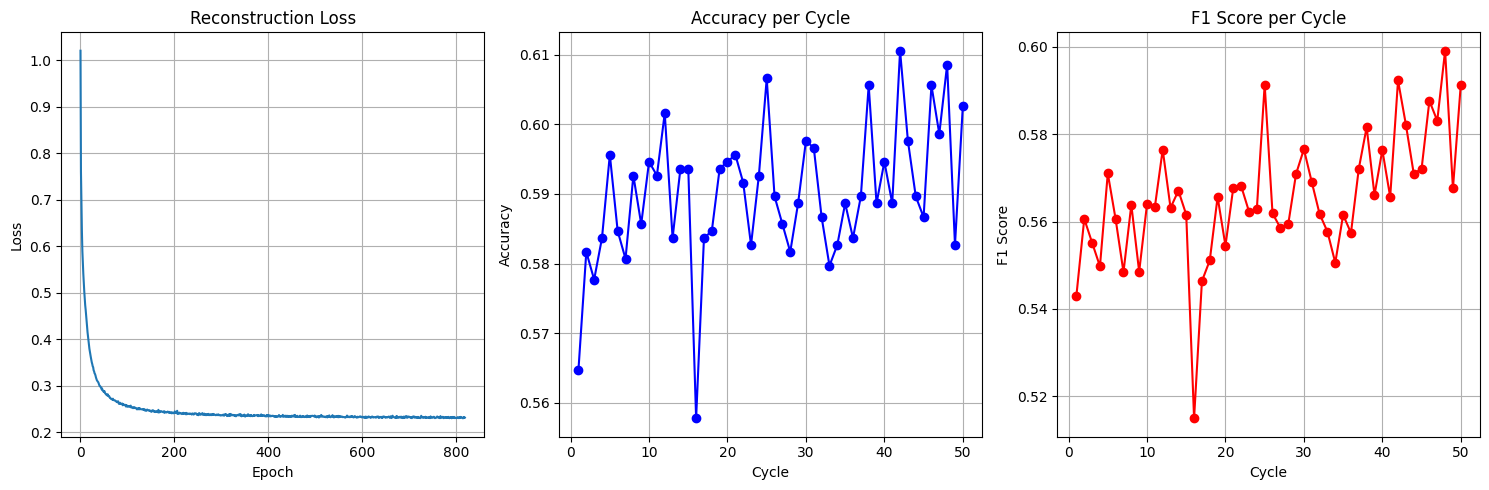

Starting training with 70 warmup epochs and 50 cycles
Input dim: 5359, Hidden dim: 256
Device: cuda

=== Warmup Phase ===
Warmup Epoch 10/70, Loss: 0.4921
Warmup Epoch 20/70, Loss: 0.3826
Warmup Epoch 30/70, Loss: 0.3296
Warmup Epoch 40/70, Loss: 0.3051
Warmup Epoch 50/70, Loss: 0.2889
Warmup Epoch 60/70, Loss: 0.2771
Warmup Epoch 70/70, Loss: 0.2706

=== Alternating Phase ===
Cycle 5/50 - Accuracy: 0.5857, F1: 0.5540
Cycle 10/50 - Accuracy: 0.5757, F1: 0.5428
Cycle 15/50 - Accuracy: 0.5876, F1: 0.5567
Cycle 20/50 - Accuracy: 0.5787, F1: 0.5324
Cycle 25/50 - Accuracy: 0.5886, F1: 0.5532
Cycle 30/50 - Accuracy: 0.6026, F1: 0.5705
Cycle 35/50 - Accuracy: 0.5896, F1: 0.5628
Cycle 40/50 - Accuracy: 0.6026, F1: 0.5754
Cycle 45/50 - Accuracy: 0.5976, F1: 0.5740
Cycle 50/50 - Accuracy: 0.5946, F1: 0.5732

=== Final Evaluation ===
Final Clustering Accuracy: 0.5837
Final Clustering F1 Score: 0.5519
Best Supervised Accuracy: 0.6145 (Cycle 47)
Best model saved to: ./saved_models\kan_autoencoder_2

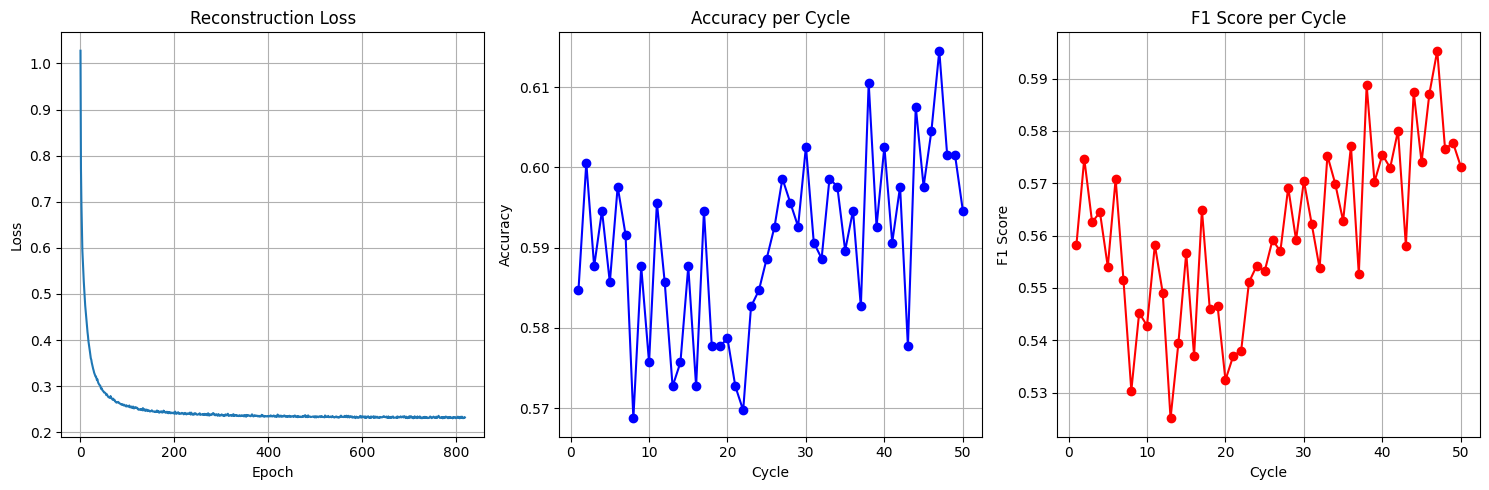

Best accuracy: 0.6145


In [36]:
# Basic usage
results = train_kan_autoencoder(X, y)

# Advanced usage with custom parameters
results = train_kan_autoencoder(
    X, y,
    random_seed=40
)

# Access results
best_model = results['model']
best_accuracy = results['history']['best_accuracy']
print(f"Best accuracy: {best_accuracy:.4f}")

# Load saved model later
loaded = load_best_model(results['best_model_path'], input_dim=X.shape[1])

In [39]:
best_model = load_best_model('./saved_models/kan_autoencoder_20250516_024700/best_model.pth', input_dim=X.shape[1])

In [41]:
# Define parameter grid
param_grid = {
    'hidden_dim': [128, 256, 512],
    'lr_encoder': [0.001, 0.002, 0.003],
    'lr_decoder': [0.0005, 0.001, 0.002],
    'n_warmup': [50, 70, 100],
    'sup_ratio': [0.2, 0.25, 0.3]
}

# Run optimization
optimization_results = optimize_hyperparameters(X, y, param_grid, n_trials=20)
best_params = optimization_results['best_params']


Trial 1/20
Parameters: {'hidden_dim': 512, 'lr_encoder': 0.002, 'lr_decoder': 0.002, 'n_warmup': 70, 'sup_ratio': 0.25}
Best accuracy: 0.6205

Trial 2/20
Parameters: {'hidden_dim': 256, 'lr_encoder': 0.001, 'lr_decoder': 0.0005, 'n_warmup': 70, 'sup_ratio': 0.3}
Best accuracy: 0.5986

Trial 3/20
Parameters: {'hidden_dim': 128, 'lr_encoder': 0.002, 'lr_decoder': 0.002, 'n_warmup': 70, 'sup_ratio': 0.2}
Best accuracy: 0.6245

Trial 4/20
Parameters: {'hidden_dim': 128, 'lr_encoder': 0.001, 'lr_decoder': 0.001, 'n_warmup': 100, 'sup_ratio': 0.2}
Best accuracy: 0.6056

Trial 5/20
Parameters: {'hidden_dim': 512, 'lr_encoder': 0.001, 'lr_decoder': 0.002, 'n_warmup': 70, 'sup_ratio': 0.2}
Best accuracy: 0.6175

Trial 6/20
Parameters: {'hidden_dim': 128, 'lr_encoder': 0.003, 'lr_decoder': 0.001, 'n_warmup': 50, 'sup_ratio': 0.3}
Best accuracy: 0.6106

Trial 7/20
Parameters: {'hidden_dim': 128, 'lr_encoder': 0.001, 'lr_decoder': 0.0005, 'n_warmup': 50, 'sup_ratio': 0.3}
Best accuracy: 0.5986

T